Code verifies consistency after replicates

In [1]:
import glob
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from scipy.optimize import root_scalar
import BootstrapFunctions as bsf

plt.rcParams['hatch.linewidth'] = 7.5

sns.set(context='paper',style='whitegrid')
plt.rcParams.update(
    {"text.usetex": True})
ibm_pal_rb = sns.blend_palette(['#648fff','#785ef0','#dc267f',],as_cmap=True)
ibm_full_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000','#000000','#ffffff']
category_palette = sns.color_palette(['#648fff','#785ef0','#dc267f',],as_cmap=True)

In [2]:
def lin_eta_xx(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*fy**2)/(1-fy-fx)**2
def lin_eta_yy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)**2)/(1-fy-fx)**2
def lin_eta_xy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)*fy)/(1-fy-fx)**2

def f_hill(x,n,K):
    if n == 0:
        return 0
    elif x == 0:
        if n < 0:
            return 1
        else:
            return 0
    return (x**n)/(K**n+x**n)

def OrGateTranscription(x,y,l,nx,kx,ny,ky,o):
    if ((nx==0) and (ny == 0)) and (o == 0):
        return l
    return l*(f_hill(x,nx,kx)+f_hill(y,ny,ky)+o)

def OrGatexsens(x,y,l,nx,kx,ny,ky,o):
    if nx == 0:
        return 0
    elif x == 0:
        return 0
    else:
        return (l*nx*(x**nx)*(kx**nx))/(OrGateTranscription(x,y,l,nx,kx,ny,ky,o)*(kx**nx + x**nx)**2)
def OrGateysens(x,y,l,nx,kx,ny,ky,o):
    if ny == 0:
        return 0
    elif y == 0:
        return 0
    else:
        return (l*ny*(y**ny)*(ky**ny))/(OrGateTranscription(x,y,l,nx,kx,ny,ky,o)*(ky**ny + y**ny)**2)

def v_hill(x,n,K):
    if n == 0:
        return np.zeros(x.shape)
    elif n < 0:
        return np.where(x==0,0,(x**n)/(K**n+x**n))
    else:
        return np.where(x==0,1,(x**n)/(K**n+x**n))

def v_OrGateTranscription(x,y,l,nx,kx,ny,ky,o):
    return l*(v_hill(x,nx,kx)+v_hill(y,ny,ky)+o)


def vec_OrGatexsens(x,y,l,nx,kx,ny,ky,o):
    if nx == 0:
        return np.zeros(x.shape)
    return np.where(x==0,0,
            (l*nx*(x**nx)*(kx**nx))/(v_OrGateTranscription(x,y,l,nx,kx,ny,ky,o)*(kx**nx + x**nx)**2))

def vec_OrGateysens(x,y,l,nx,kx,ny,ky,o):
    if ny == 0:
        return np.zeros(x.shape)
    return np.where(y==0,0,
                (l*ny*(y**ny)*(ky**ny))/(v_OrGateTranscription(x,y,l,nx,kx,ny,ky,o)*(ky**ny + y**ny)**2))


def estimated_fb_val(exy,exx,eyy):
    return (exy-exx)/(eyy-exy)

def estimated_proteinpert(exy,exx,eyy):
    return exx+eyy-2*exy

def einsum_mean_cov_vars(x,y,correction=0):
    """
    Using np.einsum, calculate, for two sets of vectors of (n,s) their means,variances, and covariances
     in each of the n samples (ex from bootstrap) across the s datapoints. Use correction to change scale
    on value (ex set to 1 for bessel)
    """
    (n,s) = x.shape #n samples [ex.num samples of bootstrap] for s datapoints
    mx = np.einsum(x,[0,1],[0])/s
    my = np.einsum(y,[0,1],[0])/s
    dx = (x.T - mx).T #transposing required to get numpy to elementwise subtract automatically
    dy = (y.T - my).T 
    cxy = np.einsum(dx,[0,1],dy,[0,1],[0])/(s-correction)
    vx = np.einsum(dx,[0,1],dx,[0,1],[0])/(s-correction)
    vy = np.einsum(dy,[0,1],dy,[0,1],[0])/(s-correction)
    return mx,my,vx,vy,cxy


In [3]:
def rhoCVplot(ax1b,fymeans,detCVratios,detrhos):
    ax1b.spines.left.set_color('k')
    ax1b.spines.right.set_color('none')
    ax1b.spines.bottom.set_position(('data',-1))
    ax1b.spines.left.set_position('zero')
    ax1b.spines.bottom.set_color('k')
    ax1b.spines.top.set_color('none')
    ax1b.xaxis.set_ticks_position('bottom')
    ax1b.yaxis.set_ticks_position('left')

    #constraint lines
    straightline = np.linspace(0,1)
    curvedline = np.linspace(1,3)
    ax1b.plot(straightline,straightline,color='#dc267f',linestyle='-',linewidth=1,alpha=1,label=r'$f_y = 0, f_x < 1$')
    ax1b.plot(curvedline,1/curvedline,'-',color='#648fff',linewidth=1,alpha=1,label=r'$f_y < 0, f_x = 1$')
    #ax1b.plot(curvedline,1/curvedline,'-',color='#648fff',linewidth=4,alpha=1)

    #positiveprotein
    ax1b.fill_between(straightline,straightline,1,color='#fe6100',alpha=0.5,zorder=-1,label=r'$f_y > 0, f_x <1$')
    #negproteinbelow
    ax1b.fill_between(straightline,straightline,-1,color='#785ef0',alpha=0.5,zorder=-1,label=r'$f_y < 0, f_x <1$')
    ax1b.fill_between(curvedline,-1,1/curvedline,color='#785ef0',alpha=0.5,zorder=-1)
    #negproteinabove
    ax1b.fill_between(curvedline,1,1/curvedline,facecolor='#648fff',edgecolor='#785ef0',hatch='/',alpha=0.5,zorder=-1,label='$f_y < 0, f_x >1$')

    #Set axes
    #ax1b.set_xlabel(r'$\mathrm{CV}_{\bar{x}}/\mathrm{CV}_{\bar{y}}$',
    #                size=25)
    ax1b.set_xticks([1,2,3])


    #ax1b.set_ylabel(r"$\rho_{\bar{x}\bar{y}}$",size=25,rotation='horizontal')
    ax1b.yaxis.set_label_coords(-0.1,0.475)
    ax1b.set_yticks([-1,-0.5,0,0.5,1])

    ax1b.set_xlim(0,3)
    ax1b.set_ylim(-1,1)

    ax1b.scatter(detCVratios,detrhos,c=np.sign(fymeans),
                cmap=matplotlib.colors.ListedColormap(['#785ef0','#dc267f','#fe6100']),edgecolors='k',s=20)
    print(np.sign(fymeans).iloc[0])

In [4]:
idx = pd.IndexSlice
def rho_CV_analyse(systemdata,byfilelist = ['fileN','fileda','filedb','sysname']):
        byfile = systemdata.groupby(byfilelist)
        variances = byfile[['<x>','<y>']].var(ddof=0)
        means = byfile.mean()
        upertmeans = byfile.agg(lambda x: x.head(3).mean())
        normcov = byfile[['<x>','<y>']].cov(ddof=0).reset_index(level=-1)
        normcov = normcov[normcov.iloc[:,0]=='<y>']['<x>']/(means['<x>']*means['<y>'])
        rhos = byfile[['<x>','<y>']].corr().reset_index(level=-1)
        rhos = rhos[rhos.iloc[:,0]=='<y>']['<x>']
        etas = variances/means[['<x>','<y>']]**2
        CVratios = np.sqrt(etas['<x>']/etas['<y>'])
        return {'means':means,'rhos':rhos,'CVratios':CVratios,
            'etas':etas,'normcov':normcov,'unpertmeans':upertmeans}
def linear_pred_rhocv(systemdata,byfilelist = ['fileN','fileda','filedb','sysname']):
    byfile = systemdata.groupby(byfilelist)
    unpertmeans = byfile.agg(lambda x: x.head(3).mean())
    means = byfile.mean()
    variances = byfile.var(ddof=0)
    pred_eta_xx = lin_eta_xx(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_eta_yy = lin_eta_yy(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_eta_xy = lin_eta_xy(variances['lambda']/means['lambda']**2,variances['gamma']/means['gamma']**2,
                             means['<F_y>'],means['<F_x>'])
    pred_rho_cv = pd.concat([pred_eta_xy,pred_eta_xx,pred_eta_yy],axis=1)
    pred_rho_cv.columns = ['eta_xy','eta_xx','eta_yy']
    pred_rho_cv['rhos'] = pred_rho_cv['eta_xy']/np.sqrt(pred_rho_cv['eta_xx']*pred_rho_cv['eta_yy'])
    pred_rho_cv['CVratios'] = np.sqrt(pred_rho_cv['eta_xx']/pred_rho_cv['eta_yy'])
    pred_rho_cv['eta_ll'] = variances['lambda']/means['lambda']**2
    pred_rho_cv['eta_gg']=variances['gamma']/means['gamma']**2
    return pred_rho_cv

def foldchange(series,about):
      return (series/about)-1

In [5]:
paramlist = ['lambda','beta_x','gamma','beta_y','nx','Kx','ny','Ky','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

In [6]:
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]

In [7]:
folders = glob.glob('Data/Replicate_IntHill1/*/*')
dat = []
failedsims = []
bootstrapdicts = []
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*data.csv',recursive=True)
    for j,f in enumerate(files):
        data = pd.read_csv(f)
        data = data.reset_index().rename(columns={'index':'perturbation'})
        numstrings = f.split("_")[-2].split('n')
        data['fileN'] = float(numstrings[0])
        data['fileda'] = float(numstrings[1])
        data['filedb'] = float(numstrings[2])
        data['sysname'] = "/".join(f.split("/")[:-1])
        if (data[['Cov Bal xx','Cov Bal yy','Cov Bal xy']] > 0.05).any(axis=1).any():
            failedsims.append(f)
            continue
        dat.append(data)
        bsdict = bsf.pertexp_interpret(data,2000)
        bsdict['fileN'] = float(numstrings[0])
        bsdict['fileda'] = float(numstrings[1])
        bsdict['filedb'] = float(numstrings[2])
        bsdict['sysname'] = "/".join(f.split("/")[:-1])
        for p in paramlist:
            try:
                bsdict[p] = data[p][0]
            except KeyError:
                bsdict[p] = 0
        bootstrapdicts.append(bsdict)
analysed_data = pd.concat(dat)

analysed_data = analysed_data[(analysed_data["filedb"]>=0.005)&(analysed_data["fileda"]>=0.005)]

pertdata = analysed_data.set_index(["fileN",'fileda','filedb','sysname','perturbation'])
#pertdata['offset'] = pertdata['offset'].fillna(1)

In [8]:
bootstrapped_res = pd.DataFrame(bootstrapdicts)
bootstrapped_res.set_index(["fileN",'fileda','filedb','sysname'],inplace=True)

In [9]:
nofy = bootstrapped_res['E[<F_y>]']==0
verticalbarcheck = bootstrapped_res['E[CVx/CVy]'].between(bootstrapped_res['2.5% (rhoxy)'],bootstrapped_res['97.5% (rhoxy)'])
horizontalbarcheck = bootstrapped_res['E[rhoxy]'].between(bootstrapped_res['2.5% (CVx/CVy)'],bootstrapped_res['97.5% (CVx/CVy)'])
nofyviolators = bootstrapped_res[nofy&~(verticalbarcheck|horizontalbarcheck)]

In [13]:
len(bootstrapped_res)

220

In [10]:
len(nofyviolators)/len(bootstrapped_res)

0.01818181818181818

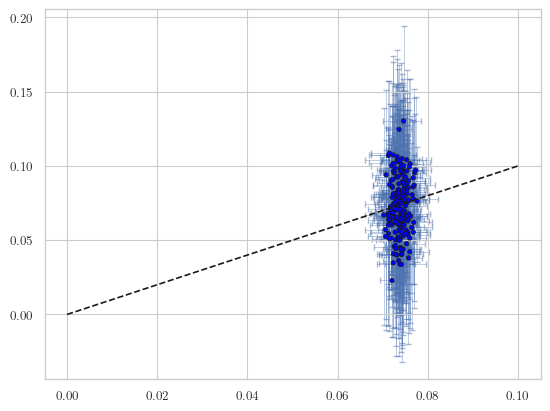

In [12]:
lowercvbar = bootstrapped_res['E[CVx/CVy]']-bootstrapped_res['2.5% (CVx/CVy)']
uppercvbar = bootstrapped_res['97.5% (CVx/CVy)']-bootstrapped_res['E[CVx/CVy]']
lowerrhobar = bootstrapped_res['E[rhoxy]']-bootstrapped_res['2.5% (rhoxy)']
upperrhobar = bootstrapped_res['97.5% (rhoxy)']-bootstrapped_res['E[rhoxy]']

plt.errorbar(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'],
             xerr=[lowercvbar,uppercvbar],
             yerr=[lowerrhobar,upperrhobar],
             capsize=2,fmt='.',zorder=0,elinewidth=0.5,c='b',alpha=0.5)

plt.scatter(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'],c=np.sign(bootstrapped_res['E[<F_y>]']),edgecolors='k',s=10,linewidths=0.5,cmap='bwr')
plt.plot(np.linspace(0,0.1),np.linspace(0,0.1),'k--')